In [5]:
#coding: utf-8

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

def execute(category):
    df=pd.read_csv('/Users/liyuefan/Documents/gtja/%sFI_0112.csv'%category,encoding='gbk')



    df['update_date']=pd.to_datetime(df['update_date'])
    df['close_yes']=df['close'].shift(1)
    df['high_yes']=df['high'].shift(1)
    df['low_yes']=df['low'].shift(1)

    df['max10']=pd.rolling_max(df['close_yes'],10)
    df['max20']=pd.rolling_max(df['close_yes'],20)
    df['max30']=pd.rolling_max(df['close_yes'],60)
    df['max60']=pd.rolling_max(df['close_yes'],100)
    df['max100']=pd.rolling_max(df['close_yes'],200)
    df['min10']=pd.rolling_min(df['close_yes'],10)
    df['min20']=pd.rolling_min(df['close_yes'],20)
    df['min30']=pd.rolling_min(df['close_yes'],60)
    df['min60']=pd.rolling_min(df['close_yes'],100)
    df['min100']=pd.rolling_min(df['close_yes'],200)

    df['close_return_yes']=np.log(df['close_yes'])
    df['close_return_yes']=df['close_return_yes'].diff()
#     df['volatility_20']=pd.rolling_mean((df['high_yes']-df['low_yes'])/df['low_yes'],20)
#     df['volatility_60']=pd.rolling_mean((df['high_yes']-df['low_yes'])/df['low_yes'],60)
#     df['volatility_100']=pd.rolling_mean((df['high_yes']-df['low_yes'])/df['low_yes'],100)
#     df['volatility_200']=pd.rolling_mean((df['high_yes']-df['low_yes'])/df['low_yes'],200)
    df['volatility_20']=pd.rolling_std(df['close_return_yes'],20)
    df['volatility_60']=pd.rolling_std(df['close_return_yes'],60)
    df['volatility_100']=pd.rolling_std(df['close_return_yes'],100)
    df['volatility_200']=pd.rolling_std(df['close_return_yes'],200)


    def sig(x1,x2,p):
        if p<x1:
            return -1
        elif p>x2:
            return 1
        else:
            return 0

    df['stop_ma10']=map(sig,df['min10'],df['max10'],df['close'])
    df['p_ma10']=map(sig,df['min20'],df['max20'],df['close'])
    df['p_ma30']=map(sig,df['min30'],df['max30'],df['close'])
    df['p_ma60']=map(sig,df['min60'],df['max60'],df['close'])
    df['p_ma100']=map(sig,df['min100'],df['max100'],df['close'])


    def dir(x):
        if x>0:
            return 1
        elif x<0:
            return -1
        else:
            return 0
    df=df.sort('update_date')


    df['p_ma10']=df['p_ma10'].fillna(method='ffill')
    df['p_ma30']=df['p_ma30'].fillna(method='ffill')
    df['p_ma60']=df['p_ma60'].fillna(method='ffill')
    df['p_ma100']=df['p_ma100'].fillna(method='ffill')

    df=df.dropna(axis=0)

    pos_mat=df.loc[:,['p_ma10','p_ma30','p_ma60','p_ma100','volatility_20','volatility_60','volatility_100','volatility_200','stop_ma10']]
    pos_mat=pos_mat.as_matrix()

    N=pos_mat.shape[0]
#     p=np.zeros(N)
    p=[np.nan for i in range(N)]
    temp_tag=0
    for i in range(0,N,1):
        if np.isnan(pos_mat[i,3])==True:
            p[i]=0
        else:
            if pos_mat[i,0]>0 and pos_mat[i,8]>=0:
                temp_tag=1
                dis_20=pos_mat[i,4]/np.mean(pos_mat[:i,4])
                dis_60=pos_mat[i,5]/np.mean(pos_mat[:i,5])
                dis_100=pos_mat[i,6]/np.mean(pos_mat[:i,6])
                dis_200=pos_mat[i,7]/np.mean(pos_mat[:i,7])
                p[i]=0.4/dis_20
                if pos_mat[i,3]>0:
                    p[i]=0.4/dis_20+0.3/dis_60+0.2/dis_100+0.1/dis_200
                elif pos_mat[i,2]>0:
                    p[i]=0.4/dis_20+0.3/dis_60+0.2/dis_100
                elif pos_mat[i,1]>0:
                    p[i]=0.4/dis_20+0.3/dis_60

            elif pos_mat[i,0]<0 and pos_mat[i,8]<=0:
                temp_tag=-1
                dis_20=pos_mat[i,4]/np.mean(pos_mat[:i,4])
                dis_60=pos_mat[i,5]/np.mean(pos_mat[:i,5])
                dis_100=pos_mat[i,6]/np.mean(pos_mat[:i,6])
                dis_200=pos_mat[i,7]/np.mean(pos_mat[:i,7])
                p[i]=-0.4/dis_20
                if pos_mat[i,3]<0:
                    p[i]=-0.4/dis_20-0.3/dis_60-0.2/dis_100-0.1/dis_200
                elif pos_mat[i,2]<0:
                    p[i]=-0.4/dis_20-0.3/dis_60-0.2/dis_100
                elif pos_mat[i,1]<0:
                    p[i]=-0.4/dis_20-0.3/dis_60

#             elif temp_tag>0 and pos_mat[i,8]==-1:
#                 temp_tag=0
#                 print 'stop'
#                 p[i]=0
#             elif temp_tag<0 and pos_mat[i,8]==1:
#                 temp_tag=0
#                 print 'stop'
#                 p[i]=0
#             else:
#                 p[i]=np.nan



    df['position']=p
    df['position']=df['position'].fillna(method='ffill')

    df['close_return']=np.log(df['close'])
    df['close_return']=df['close_return'].diff()

    df['position']=df['position'].shift(2)


    df['daily_return']=df['position']*df['close_return']
    
    
    
    close_return=np.array(df['daily_return'])
    position=np.array(df['position'])
    for i in range(1,len(position)):
        if position[i]!=position[i-1]:
            close_return[i-1]=close_return[i-1]-1./10000
            close_return[i]=close_return[i]-1./10000
        else:
            pass
    df['daily_return']=close_return
    
    

    df['cum_return']=df['daily_return'].cumsum()

    df.index=[df['update_date']]
    return df

In [6]:
def portfolio(comp1,comp2,corr):
    if type(comp1)==str and type(comp2)==str:
        comp1=execute(comp1)
        comp2=execute(comp2)
    else:
        comp1=comp1
        comp2=comp2
    comp1=comp1.rename(columns={'daily_return':'daily_return_1','close_return':'close_return_1'})
    comp2=comp2.rename(columns={'daily_return':'daily_return_2','close_return':'close_return_2'})
    t=pd.merge(comp1,comp2,on='update_date',how='inner')

    tt=t.loc[:,['update_date','daily_return_1','daily_return_2','close_return_1','close_return_2']]
    

    tt['portfolio_return']=0.5*tt['daily_return_1']+0.5*tt['daily_return_2']
    tt['close_return']=0.5*tt['close_return_1']+0.5*tt['close_return_2']

    tt['port_cum_return']=tt['portfolio_return'].cumsum()
    tt['port_cummax']=tt['port_cum_return'].cummax()
    tt['port_drawdown']=tt['port_cum_return']-tt['port_cummax']
    tt['update_date']=pd.to_datetime(tt['update_date'])
    return tt

In [7]:
def port_port(port1,port2):
    port1=port1.drop(['daily_return_1','daily_return_2','close_return_1','close_return_2'],axis=1)
    port2=port2.drop(['daily_return_1','daily_return_2','close_return_1','close_return_2'],axis=1)
    port1=port1.rename(columns={'portfolio_return':'daily_return_1','close_return':'close_return_1'})
    port2=port2.rename(columns={'portfolio_return':'daily_return_2','close_return':'close_return_2'})
    
    t=pd.merge(port1,port2,on='update_date',how='inner')

    tt=t.loc[:,['update_date','daily_return_1','daily_return_2','close_return_1','close_return_2']]

    
    tt['portfolio_return']=0.5*tt['daily_return_1']+0.5*tt['daily_return_2']
    tt['close_return']=0.5*tt['close_return_1']+tt['close_return_2']

    tt['port_cum_return']=tt['portfolio_return'].cumsum()
    tt['port_cummax']=tt['port_cum_return'].cummax()
    tt['port_drawdown']=tt['port_cum_return']-tt['port_cummax']
    return tt

In [8]:
def plot_figure(tt):
    drawdown_interval_right=np.argmin(tt['port_drawdown'])
    drawdown_interval_left=np.argwhere(tt['port_cummax']==tt['port_cummax'][drawdown_interval_right])[0,0]
    plt.figure(figsize=(15,10))
    plt.plot(tt['update_date'],tt['port_cum_return'],label='cum:return:%.2f'%np.array(tt['port_cum_return'])[-1])
    plt.vlines(tt['update_date'][drawdown_interval_left:drawdown_interval_right].values,np.min(tt['port_cum_return']),np.max(tt['port_cum_return']),colors='r',linestyles='dashed',alpha=0.2,label='max_drawdown_interval:%.2f'%np.min(tt['port_drawdown']))
    plt.legend()
    print 'return/drawdown = ', np.array(tt['port_cum_return'])[-1]/np.abs(np.min(tt['port_drawdown']))

In [9]:
# df.to_csv('df.csv',encoding='gbk')

In [10]:
# df.to_csv('df.csv',encoding='gbk')

In [11]:
from sklearn.decomposition import PCA as PCA
def comp_portfolio_pca(asset_pool):
    import itertools
    import scipy as sp
    all_assets=pd.DataFrame(columns=['update_date'])
    for a in asset_pool:
        tmp=execute(a)
        tmp=tmp.loc[:,['update_date','close_return']]
        tmp=tmp.rename(columns={'close_return':'%s'%a})
        all_assets=pd.merge(all_assets,tmp,on='update_date',how='outer')
    all_assets['update_date']=pd.to_datetime(all_assets['update_date'])
    all_assets['year']=all_assets['update_date'].apply(lambda x: x.year)
    
    selected_port_dict={}
    for year in pd.unique(all_assets['year']):
        tmp=all_assets[all_assets['year']==year]
        tmp=tmp.dropna(how='all',axis=1)
        col_list=[col for col in tmp.columns if col!='update_date' and col!='year']
        corr_dict={}
        mat=tmp[col_list]
        mat=mat.fillna(0)
        mat=mat.as_matrix()
        pca=PCA(whiten=True)
        pca.fit(mat)
        com=pca.components_[0]
        com=np.abs(com)
        com=list(com)
        com1=np.argmax(com)
        del com[com1]
        com2=np.argmax(com)
        del com[com2]
        com3=np.argmax(com)
        del com[com3]
        com4=np.argmax(com)

        selected_port_dict[year+1]=[(col_list[com1],col_list[com2]),(col_list[com3],col_list[com4])]
        
        print year+1, com1,com2,com3,com4
    return selected_port_dict
    
                

In [12]:
def comp_portfolio(asset_pool):
    import itertools
    import scipy as sp
    import scipy.stats as stats
    all_assets=pd.DataFrame(columns=['update_date'])
    for a in asset_pool:
        tmp=execute(a)
#         tmp=tmp.loc[:,['update_date','daily_return']]
        tmp=tmp.loc[:,['update_date','close_return']] 
#         tmp=tmp.rename(columns={'daily_return':'%s'%a})
        tmp=tmp.rename(columns={'close_return':'%s'%a})
        all_assets=pd.merge(all_assets,tmp,on='update_date',how='outer')
    all_assets['update_date']=pd.to_datetime(all_assets['update_date'])
    all_assets['year']=all_assets['update_date'].apply(lambda x: x.year)
    selected_port_dict={}
    for year in pd.unique(all_assets['year']):
        tmp=all_assets[all_assets['year']==year]
        tmp=tmp.dropna(how='all',axis=1)
        col_list=[col for col in tmp.columns if col!='update_date' and col!='year']
        corr_dict={}
        for item in itertools.product(col_list,col_list):
            if item[0]!=item[1]:
                cor_mat=tmp.loc[:,item]
                cor_mat=cor_mat.dropna(axis=0)
                cor_mat=cor_mat.as_matrix()
#                 corr=sp.corrcoef(cor_mat.T)
                corr,p=stats.pearsonr(cor_mat[:,0],cor_mat[:,1])
#                 corr=corr[0,1]
                if p>0.01:
                    corr_dict[item]=np.abs(corr)
                else:
                    corr_dict[item]=np.nan
            else:
                pass
        corr_dict_items=filter(lambda x:np.isnan(x[1])==False,corr_dict.items())
        if len(corr_dict_items)>=4:
            selected_port=[item for item in sorted(corr_dict_items, key=lambda d:d[1],reverse=False)][0:3]
            selected_port_1=selected_port[0]
            selected_list=[x for x in selected_port_1[0]]
            for i in range(len(selected_port)):
                tmp_1=selected_port[i][0]
                if tmp_1[0] not in selected_list or tmp_1[1] not in selected_list:
                    selected_port_2=selected_port[i]
                else:
                    pass
            selected_port_dict[year+1]=[selected_port_1,selected_port_2]
        
            print year+1, selected_port_1, '%.3f'%selected_port_dict[year+1][0][1]
            print year+1, selected_port_2, '%.3f'%selected_port_dict[year+1][1][1]
        #如果无法通过相关性检验，则选择波动性最低的几个品种
        else:
            tmp_=tmp.drop(['update_date','year'],axis=1)
            
            std_list=np.std(tmp_)
            std_list=std_list.to_dict()
            std_list=filter(lambda x:np.isnan(x[1])==False,std_list.items())
            if len(std_list)>=4:
                selected_port=[item for item in sorted(std_list,key=lambda d:d[1],reverse=False)][0:4]
                selected_port_1=((selected_port[0][0],selected_port[1][0]),0)
                selected_port_2=((selected_port[2][0],selected_port[3][0]),0)
                selected_port_dict[year+1]=[selected_port_1,selected_port_2]
                print 'std min: ',year+1, selected_port_1#, '%.3f'%selected_port_dict[year+1][0][1]
                print 'std min: ',year+1, selected_port_2#, '%.3f'%selected_port_dict[year+1][1][1]
            #如果还不行，那就直接按照过去一年的累积收益率高低进行排序，选择去年收益率最低的做一个反转策略
            else:
            
            
            
                mean_list=np.abs(np.mean(tmp_))
                mean_list=mean_list.to_dict()
                mean_list=filter(lambda x:np.isnan(x[1])==False,mean_list.items())


                if len(mean_list)>=4:
                    selected_port=[item for item in sorted(mean_list,key=lambda d:d[1],reverse=False)][0:4]
                    selected_port_1=((selected_port[0][0],selected_port[1][0]),0)
                    selected_port_2=((selected_port[2][0],selected_port[3][0]),0)
                    selected_port_dict[year+1]=[selected_port_1,selected_port_2]
                    print 'mean reverse: ',year+1, selected_port_1#, '%.3f'%selected_port_dict[year+1][0][1]
                    print 'mean reverse: ',year+1, selected_port_2#, '%.3f'%selected_port_dict[year+1][1][1]
                #如果这样都不行的话...
                else:
                    pass
                    print u'另请高明：',year+1
                    

                
            
    return selected_port_dict
    
                

In [13]:
asset_pool=['CU','ZN','PB','AL','NI','I','JM','J','WH','ZC','Y','TA','SR','RU','RM','P','M','C']

In [14]:
a=comp_portfolio(asset_pool)

2009 (('SR', 'RU'), 0.011482861274397963) 0.011
2009 (('SR', 'TA'), 0.026715819486214227) 0.027
std min:  2010 (('C', 'AL'), 0)
std min:  2010 (('SR', 'TA'), 0)
std min:  2011 (('C', 'M'), 0)
std min:  2011 (('Y', 'AL'), 0)
std min:  2012 (('C', 'AL'), 0)
std min:  2012 (('M', 'SR'), 0)
std min:  2013 (('C', 'AL'), 0)
std min:  2013 (('PB', 'ZN'), 0)
2014 (('RM', 'TA'), 0.010487978197843084) 0.010
2014 (('CU', 'WH'), 0.020557927930774114) 0.021
2015 (('ZN', 'C'), 0.0036662228937167688) 0.004
2015 (('TA', 'C'), 0.0043726208227771917) 0.004
2016 (('I', 'C'), 0.059758390044729486) 0.060
2016 (('C', 'ZC'), 0.074407407535018677) 0.074
2017 (('PB', 'WH'), 0.0015806961621015771) 0.002
2017 (('WH', 'I'), 0.0032679604026980653) 0.003
2018 (('JM', 'P'), 0.0024790335261145489) 0.002
2018 (('P', 'J'), 0.0024790335261145489) 0.002


In [15]:
mixed_port=pd.DataFrame()
for item in a.items():
    print item[0]

    
#####如果取前两对############
    corr_1=item[1][0][1]
    corr_2=item[1][1][1]
    tmp_1=portfolio(item[1][0][0][0],item[1][0][0][1],corr_1)
    tmp_1['update_date']=pd.to_datetime(tmp_1['update_date'])
    tmp_1=tmp_1[tmp_1['update_date'].apply(lambda x:x.year)==item[0]]
    tmp_2=portfolio(item[1][1][0][0],item[1][1][0][1],corr_2)
    tmp_2['update_date']=pd.to_datetime(tmp_2['update_date'])
    tmp_2=tmp_2[tmp_2['update_date'].apply(lambda x:x.year)==item[0]]
    tmp=port_port(tmp_1,tmp_2)

#####如果只取一对###########
#     tmp=portfolio(item[1][0][0][0],item[1][0][0][1])
#     tmp['update_date']=pd.to_datetime(tmp['update_date'])
#     tmp=tmp[tmp['update_date'].apply(lambda x:x.year)==item[0]]
##########################



#####PCA_1##################
#     print item[1]
#     tmp=portfolio(item[1][0][0],item[1][0][1])
#     tmp['update_date']=pd.to_datetime(tmp['update_date'])
#     tmp=tmp[tmp['update_date'].apply(lambda x:x.year)==item[0]]

#########################

#######PCA_2################
#     print item
#     tmp_1=portfolio(item[1][0][0],item[1][0][1])
#     tmp_1['update_date']=pd.to_datetime(tmp_1['update_date'])
#     tmp_1=tmp_1[tmp_1['update_date'].apply(lambda x:x.year)==item[0]]
#     tmp_2=portfolio(item[1][1][0],item[1][1][1])
#     tmp_2['update_date']=pd.to_datetime(tmp_2['update_date'])
#     tmp_2=tmp_2[tmp_2['update_date'].apply(lambda x:x.year)==item[0]]
#     tmp=port_port(tmp_1,tmp_2)
# ############################    
    


    
    if len(tmp)>0:
        tmp['update_date']=pd.to_datetime(tmp['update_date'])
        tmp=tmp[tmp['update_date'].apply(lambda x:x.year)==item[0]]
        tmp=tmp.loc[:,['update_date','portfolio_return','close_return']]
        mixed_port=mixed_port.append(tmp)
    else:
        print 'no data!'
        pass
    

2016
2017
2018
no data!
2009
2010
2011
2012
2013
2014
2015


In [16]:
mixed_port=mixed_port.sort('update_date')

In [17]:
mixed_port['cum_return']=mixed_port['portfolio_return'].cumsum()
mixed_port['benchmark']=mixed_port['close_return'].cumsum()
mixed_port['cum_max']=mixed_port['cum_return'].cummax()
mixed_port['drawdown']=mixed_port['cum_return']-mixed_port['cum_max']

In [18]:
np.min(mixed_port['drawdown']/(1+mixed_port['cum_return']))

-0.16678374471659579

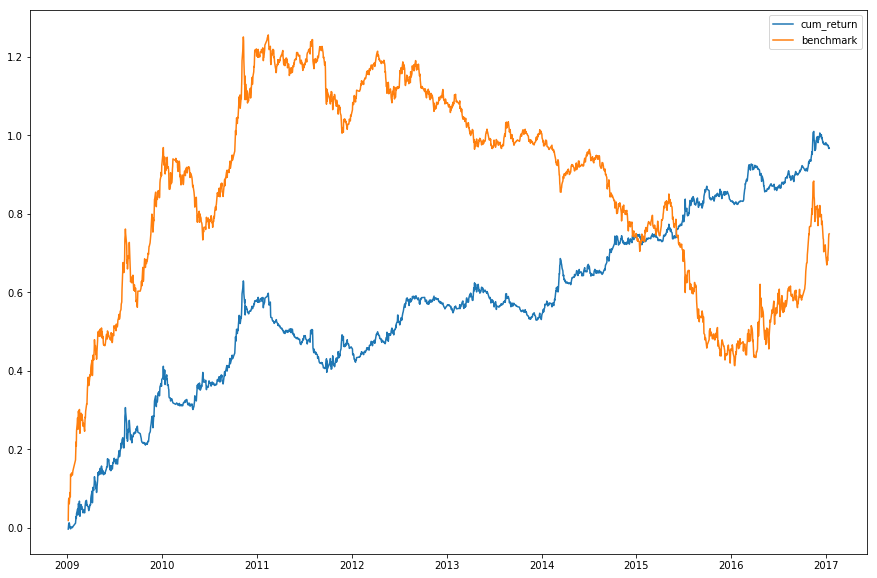

In [19]:
plt.figure(figsize=(15,10))
plt.plot(mixed_port['update_date'],mixed_port['cum_return'])
plt.plot(mixed_port['update_date'],mixed_port['benchmark'],label='benchmark')
plt.legend()

In [20]:
mixed_port['year']=mixed_port['update_date'].apply(lambda x: x.year)
each_year_return=mixed_port.groupby(['year']).portfolio_return.sum()

In [21]:
each_year_return

year
2009    0.377802
2010    0.199098
2011   -0.115823
2012    0.102516
2013   -0.032984
2014    0.208199
2015    0.093317
2016    0.148970
2017   -0.014495
Name: portfolio_return, dtype: float64

In [22]:
for i,j in mixed_port.groupby(['year']):
    sharpe=(np.mean(j['portfolio_return'])*252)/(np.std(mixed_port['portfolio_return'])*np.sqrt(252))
    print i, sharpe

2009 3.38139304798
2010 1.7966896599
2011 -1.03663866909
2012 0.921314125726
2013 -0.302656192941
2014 1.85580943609
2015 0.835202617588
2016 1.33330970682
2017 -3.95695505468


夏普

In [23]:
(np.mean(mixed_port['portfolio_return'])*252)/(np.std(mixed_port['portfolio_return'])*np.sqrt(252))

1.0814041000708285